In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets -q
!pip install --upgrade sympy -q
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import Dataset
import pandas as pd
import requests
import os
import numpy as np
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 52.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but y

In [ ]:
#parameters
device = torch.device("cuda")
max_length = 2500 #context window size
model_name = "EleutherAI/pythia-410m" #model used as base

#Loading and Cleaning Old Bailey Data

Total number of documents: 3090
Number of guilty verdicts: 1910
Number of not guilty verdicts: 753
Max word count of the evidence column: 14805.0
Number of valid rows: 2566


,full_text,verdict,evidence,evidence_length,valid
0,was indicted for feloniously breaking and ente...,GUILTY,was indicted for feloniously breaking and ente...,76.00,1
1,"was indicted for stealing, on the 7th of May ,...",GUILTY,"was indicted for stealing, on the 7th of May ,...",401.25,1
2,was indicted for burglariously breaking and en...,GUILTY,was indicted for burglariously breaking and en...,867.50,1
3,"was indicted for feloniously assaulting , on t...",GUILTY,"was indicted for feloniously assaulting , on t...",680.50,1
4,"was indicted for stealing, on the 9th of Decem...",,NaN,NaN,0
5,"was indicted for feloniously assaulting , on t...",GUILTY,"was indicted for feloniously assaulting , on t...",505.50,1
6,"was indicted for stealing, on the 14th of Dece...",,NaN,NaN,0
7,"was indicted for stealing, on the 5th of Janua...",,NaN,NaN,0
8,"and were indicted for stealing, on the 31st of...",GUILTY,"and were indicted for stealing, on the 31st of...",340.00,1
9,"and were indicted for stealing, on the 5th of ...",NOT GUILTY,"and were indicted for stealing, on the 5th of ...",1024.75,1


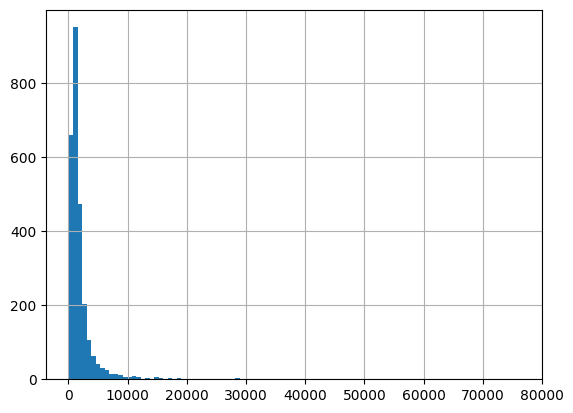

In [ ]:

url = "https://raw.githubusercontent.com/wilkens-teaching/info3350-f24/main/data/old_bailey/old_bailey.txt"
old_bailey_data = requests.get(url).text

# Split on consecutive newlines to create bailey
bailey = [doc for doc in old_bailey_data.split('\n\n')]
bailey_df = pd.DataFrame({'full_text': bailey, 'verdict': ''})

for index, row in bailey_df.iterrows():
  if " NOT GUILTY ." in row['full_text']:
    bailey_df.loc[index, 'verdict'] = 'NOT GUILTY'
    bailey_df.loc[index, 'evidence'] = row['full_text'][:row['full_text'].rfind(' NOT GUILTY .')]
  elif " GUILTY ." in row['full_text'] and " NOT GUILTY ." not in row['full_text']:
    bailey_df.loc[index, 'verdict'] = 'GUILTY'
    bailey_df.loc[index, 'evidence'] = row['full_text'][:row['full_text'].rfind(' GUILTY .')]
# if " not guilty ." in row['full_text'].lower()
# elif " guilty ." in row['full_text'].lower() and " not guilty ." not in row['full_text'].lower():

print(f"Total number of documents: {len(bailey_df)}")
print(f"Number of guilty verdicts: {len(bailey_df[bailey_df['verdict'] == 'GUILTY'])}")
print(f"Number of not guilty verdicts: {len(bailey_df[bailey_df['verdict'] == 'NOT GUILTY'])}")
print(f"Max word count of the evidence column: {bailey_df['evidence'].str.split().str.len().max()}")

bailey_df['evidence_length'] = bailey_df['evidence'].str.len() / 4
bailey_df['evidence'].str.len().hist(bins=100)
bailey_df['valid'] = bailey_df['evidence_length'].apply(lambda x: 1 if x < max_length*0.75 else 0)
print(f"Number of valid rows: {bailey_df[bailey_df['valid'] == 1].shape[0]}")
bailey_df.head(10)

#Fine Tuning

In [ ]:
model_name = model_name

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# Move model to device
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.eos_token_id

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/911M [00:00<?, ?B/s]

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [ ]:
def prepare_dataset(questions, answers):
    return Dataset.from_dict({"text": [f"Arguement: {q}\nVerdict: {a}" for q, a in zip(questions, answers)]})

def tokenize_function(examples, tokenizer, max_length):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=max_length)

questions_df = bailey_df[bailey_df["valid"] == 1]
dataset = prepare_dataset(questions_df["evidence"], questions_df["verdict"])

In [ ]:
dataset

Dataset({
    features: ['text'],
    num_rows: 2566
})

In [ ]:
# Set up data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Preprocess the dataset
max_length = max_length
tokenized_dataset = dataset.map(
    lambda examples: tokenize_function(examples, tokenizer, max_length),
    batched=True,
    remove_columns=dataset.column_names
)

Map:   0%|          | 0/2566 [00:00<?, ? examples/s]

In [ ]:
train_test = tokenized_dataset.train_test_split(test_size=0.1)

In [ ]:
train_test

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 2309
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 257
    })
})

In [ ]:
dataset[0], tokenized_dataset[0]

({'text': "Arguement: was indicted for feloniously breaking and entering the dwelling-house of and , about three o'clock in the afternoon of the 4th of January , at St. James, Westminster ( and others being therein), and stealing, one coat, value 18 s., and one sheet, value 2 s., the goods of the said . The prisoner pleaded,\nVerdict: GUILTY"},
 {'input_ids': [2906,
   4297,
   1003,
   27,
   369,
   38455,
   323,
   48935,
   8140,
   10155,
   285,
   11734,
   253,
   31824,
   14,
   5967,
   273,
   285,
   1157,
   670,
   1264,
   258,
   8,
   13273,
   275,
   253,
   9055,
   273,
   253,
   577,
   394,
   273,
   4247,
   1157,
   387,
   659,
   15,
   5490,
   13,
   34328,
   313,
   285,
   2571,
   1146,
   15308,
   582,
   285,
   27980,
   13,
   581,
   11959,
   13,
   1318,
   1283,
   256,
   904,
   285,
   581,
   8335,
   13,
   1318,
   374,
   256,
   904,
   253,
   10229,
   273,
   253,
   753,
   964,
   380,
   18897,
   23383,
   13,
   187,
   1075

In [ ]:
output_dir = "./fine_tuned_causal_model"

# Set up training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to="none",
    per_device_train_batch_size=16,
    num_train_epochs=5,
    save_steps=2000,
    save_total_limit=2,
    logging_dir=f"{output_dir}/logs",
    gradient_checkpointing=True,
    gradient_accumulation_steps=15,
    logging_steps=10,
    learning_rate=1e-5,
    warmup_steps=5,
    logging_strategy="epoch",
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=1000,
    load_best_model_at_end=True,
    fp16 = True,
  )

In [ ]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test["train"],
    eval_dataset=train_test["test"],
    data_collator=data_collator,
)
trainer.can_return_loss = True

# Start training
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=45, training_loss=27.126640150282118, metrics={'train_runtime': 1314.12, 'train_samples_per_second': 8.785, 'train_steps_per_second': 0.034, 'total_flos': 5.53874085888e+16, 'train_loss': 27.126640150282118, 'epoch': 4.517241379310345})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.9135011434555054,
 'eval_runtime': 8.4281,
 'eval_samples_per_second': 30.493,
 'eval_steps_per_second': 3.915,
 'epoch': 4.517241379310345}

In [ ]:
save_directory = "/content/drive/My Drive/410pythia604"
os.makedirs(save_directory, exist_ok=True)

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")


Model and tokenizer saved to /content/drive/My Drive/410pythia604


In [ ]:
if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.eos_token_id

def generate_verdict(prompt):
    prompt = prompt + "\nVerdict: "
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

    output = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=8,  # Limit output to 2 tokens
        do_sample=False,   # Use greedy decoding for deterministic output
        pad_token_id=model.config.pad_token_id
    )

    verdict = tokenizer.decode(output[0], skip_special_tokens=True)
    return verdict

generate_verdict("hey there")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


'hey there\nVerdict:  GUILTY . Aged 18.'

In [ ]:
bailey_df.head()

,full_text,verdict,evidence,evidence_length,valid
0,was indicted for feloniously breaking and ente...,GUILTY,was indicted for feloniously breaking and ente...,76.00,1
1,"was indicted for stealing, on the 7th of May ,...",GUILTY,"was indicted for stealing, on the 7th of May ,...",401.25,1
2,was indicted for burglariously breaking and en...,GUILTY,was indicted for burglariously breaking and en...,867.50,1
3,"was indicted for feloniously assaulting , on t...",GUILTY,"was indicted for feloniously assaulting , on t...",680.50,1
4,"was indicted for stealing, on the 9th of Decem...",,NaN,NaN,0


In [ ]:
bailey_df.head()

,full_text,verdict,evidence,evidence_length,valid
0,was indicted for feloniously breaking and ente...,GUILTY,was indicted for feloniously breaking and ente...,76.00,1
1,"was indicted for stealing, on the 7th of May ,...",GUILTY,"was indicted for stealing, on the 7th of May ,...",401.25,1
2,was indicted for burglariously breaking and en...,GUILTY,was indicted for burglariously breaking and en...,867.50,1
3,"was indicted for feloniously assaulting , on t...",GUILTY,"was indicted for feloniously assaulting , on t...",680.50,1
4,"was indicted for stealing, on the 9th of Decem...",,NaN,NaN,0


In [ ]:
bailey_df['generated_verdict'] = ''

for row in tqdm(bailey_df[bailey_df['evidence'].notna()].itertuples(), total=len(bailey_df[bailey_df['evidence'].notna()])):
    gen_verdict = generate_verdict(f"{row.evidence}\nVerdict: ")
    if "NOT GUILTY" in gen_verdict:
        bailey_df.at[row.Index, 'generated_verdict'] = 'NOT GUILTY'
    elif "GUILTY" in gen_verdict and "NOT GUILTY" not in gen_verdict:
        bailey_df.at[row.Index, 'generated_verdict'] = 'GUILTY'
    else:
        bailey_df.at[row.Index, 'generated_verdict'] = 'UNKNOWN'

for row in tqdm(bailey_df[bailey_df['evidence'].isna()].itertuples(), total=len(bailey_df[bailey_df['evidence'].isna()])):
  gen_verdict = generate_verdict(f"{row.full_text}\nVerdict: ")
  if "NOT GUILTY" in gen_verdict:
        bailey_df.at[row.Index, 'generated_verdict'] = 'NOT GUILTY'
  elif "GUILTY" in gen_verdict and "NOT GUILTY" not in gen_verdict:
      bailey_df.at[row.Index, 'generated_verdict'] = 'GUILTY'
  else:
      bailey_df.at[row.Index, 'generated_verdict'] = 'UNKNOWN'

  0%|          | 0/2663 [00:00<?, ?it/s]

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


  0%|          | 0/427 [00:00<?, ?it/s]

In [ ]:
y_pred = bailey_df[bailey_df['evidence'].notna()]['generated_verdict']
y_true = bailey_df[bailey_df['evidence'].notna()]['verdict']
print("model classification:\n")
print(classification_report(y_true, y_pred))
print("random classification:\n")
y_pred = np.random.choice(['NOT GUILTY', 'GUILTY'], size=len(y_true), p=[0.5, 0.5])
print(classification_report(y_true, y_pred))
print("majority class (guilty) classification:\n")
y_pred = np.random.choice(['GUILTY', 'GUILTY'], size=len(y_true), p=[0.5, 0.5])
print(classification_report(y_true, y_pred))

model classification:

              precision    recall  f1-score   support

      GUILTY       0.77      0.18      0.29      1910
  NOT GUILTY       0.29      0.84      0.43       753
     UNKNOWN       0.00      0.00      0.00         0

    accuracy                           0.36      2663
   macro avg       0.35      0.34      0.24      2663
weighted avg       0.63      0.36      0.33      2663

random classification:

              precision    recall  f1-score   support

      GUILTY       0.71      0.50      0.59      1910
  NOT GUILTY       0.28      0.49      0.35       753

    accuracy                           0.50      2663
   macro avg       0.50      0.49      0.47      2663
weighted avg       0.59      0.50      0.52      2663

majority class (guilty) classification:

              precision    recall  f1-score   support

      GUILTY       0.72      1.00      0.84      1910
  NOT GUILTY       0.00      0.00      0.00       753

    accuracy                           0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

In [ ]:
generate_verdict("Argument: DOJ claimed AT&T’s monopoly on long-distance services resulted from control over local Bell companies, preventing competitors from accessing the network.\nVerdict: ")

'Argument: DOJ claimed AT&T’s monopoly on long-distance services resulted from control over local Bell companies, preventing competitors from accessing the network.\nVerdict: \nVerdict: \nNOT GUILTY.\n\n'

In [ ]:
generate_verdict("Argument: DOJ argued that American Express’ anti-steering rules prevented merchants from promoting alternative cards with lower fees, limiting competition.\nVerdict: ")

'Argument: DOJ argued that American Express’ anti-steering rules prevented merchants from promoting alternative cards with lower fees, limiting competition.\nVerdict: \nVerdict: \nWILLIAM H. BARR'

In [ ]:
generate_verdict("Argument: EU claimed TikTok engaged in unfair data collection practices impacting user privacy and limiting competition for user attention.\nVerdict: ")

'Argument: EU claimed TikTok engaged in unfair data collection practices impacting user privacy and limiting competition for user attention.\nVerdict: \nVerdict: \nFor the prosecution, MR. .'

In [ ]:
for index, row in bailey_df.head(10).iterrows():
    print(f"Row {index + 1}:")
    print(f"  Verdict:           {row['verdict']}")
    print(f"  Generated Verdict: {row['generated_verdict']}")
    print(f"  Full Text:         {row['full_text']}")
    print("-" * 80)

Row 1:
  Verdict:           GUILTY
  Generated Verdict: NOT GUILTY
  Full Text:         was indicted for feloniously breaking and entering the dwelling-house of and , about three o'clock in the afternoon of the 4th of January , at St. James, Westminster ( and others being therein), and stealing, one coat, value 18 s., and one sheet, value 2 s., the goods of the said . The prisoner pleaded, GUILTY . - DEATH . Aged 45. Before Mr. Recorder.
--------------------------------------------------------------------------------
Row 2:
  Verdict:           GUILTY
  Generated Verdict: NOT GUILTY
  Full Text:         was indicted for stealing, on the 7th of May , two loaves of bread, value 18 d. , the goods of . . I am a baker , and live in Oxford-market. On the 7th of May I set my basket down in Park-lane, opposite Grosvenor Gate . I stood just by the gate, and saw the prisoner come along with a baker's barrow, a basket, and bread; he stopped at my basket, then went up to it, uncovered the flannel,

In [ ]:
#TAKE THE GUILT QUIZ. SEE IF YOU DO BETTER THAN THE MODEL!
short_texts = bailey_df[bailey_df['evidence'].str.len() < 300]

# Prints the evidence
for index, row in short_texts.iterrows():
  print(f"Row {index}:")
  print(f"  Evidence: {row['evidence']}")
  print("-" * 80)
#WRITE DOWN YOUR ANSWERS AND CHECK ON THE NEXT CELL

Row 39:
  Evidence: *, , and were severally and separately indicted for feloniously and without lawful excuse, having in their possession, forged Bank of England notes, they well knowing them to be forged . To which indictments the prisoners severally and separately pleaded,
--------------------------------------------------------------------------------
Row 40:
  Evidence: , and were again indicted for disposing of and putting away forged notes, with intent to defraud the . MR. REYNOLDS for the Prosecution, declined offering any evidence.
--------------------------------------------------------------------------------
Row 81:
  Evidence: was again indicted for stealing, on the 20th of August, 1817 , one gelding, price 40 l. , the property of . MR. ANDERSON. My Lord, I do not wish the case to proceed.
--------------------------------------------------------------------------------
Row 88:
  Evidence: was indicted for perjury .
-----------------------------------------------------------

In [ ]:
for index, row in short_texts.iterrows():
  print(f"Row {index}:")
  print(f"  Correct Answer: {row['verdict']}")
  print("-" * 80)

Row 39:
  Correct Answer: GUILTY
--------------------------------------------------------------------------------
Row 40:
  Correct Answer: NOT GUILTY
--------------------------------------------------------------------------------
Row 81:
  Correct Answer: NOT GUILTY
--------------------------------------------------------------------------------
Row 88:
  Correct Answer: NOT GUILTY
--------------------------------------------------------------------------------
Row 92:
  Correct Answer: GUILTY
--------------------------------------------------------------------------------
Row 118:
  Correct Answer: NOT GUILTY
--------------------------------------------------------------------------------
Row 154:
  Correct Answer: GUILTY
--------------------------------------------------------------------------------
Row 155:
  Correct Answer: NOT GUILTY
--------------------------------------------------------------------------------
Row 160:
  Correct Answer: NOT GUILTY
---------------------------

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

# Example data
y_true = [0, 0, 1, 1]  # True binary labels
y_scores = [0.1, 0.4, 0.35, 0.8]  # Predicted probabilities for the positive class

# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Plot ROC curve
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve")
plt.show()